In [18]:
from __future__ import absolute_import, division, print_function, unicode_literals

#from IPython import get_ipython
#get_ipython().magic('reset -sf')

import torch
torch.cuda.is_available()


from cycler import cycler
import tensorflow as tf
import autograd.numpy as np
import matplotlib.pyplot as plt
from sys import stdout
from autograd import grad
import time 


if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

devicecpu=torch.device("cpu")

#plt.close('all')

Running on the CPU


In [19]:
gamma2=0.01
nu=0.01
sigma=3.


def getdata_train(Ntrain):
    np.random.seed(111)
    #x = np.random.uniform(size=(Ntrain,1),low=-5,high=5)
    x=(np.linspace(-5,5,Ntrain))[...,np.newaxis]
    noise = np.random.normal(scale=sigma,size=(Ntrain,1))
    y = x**2 + x + noise 
    return torch.from_numpy(x), torch.from_numpy(y)

def getdata_test(Ntest):
    x=(np.linspace(-5,5,Ntest)+ 0.5/Ntest)[...,np.newaxis]
    y= x**2 + x + np.random.normal(scale=3.0,size=(Ntest,1))
    return  torch.from_numpy(x), torch.from_numpy(y)



In [20]:
#return result of an input after propagation in space F_2

def xtopsi2_torch(x):
    if random2 == "true":
        p=x.shape[1]  #train input dimension --> column vector with 100 rows
        np.random.seed(11)
        bias2=torch.from_numpy(0.1*np.random.randn(D2))  #b_2^2 with distribution 0.1 * N(0,1) 
        W2=torch.from_numpy(1.5*np.divide(np.random.randn(p, D2),np.sqrt(p)))   
        #W_2^2 with corresponding distribution
        e=torch.matmul(x,W2)+bias2
    else: 
        e=x
        
    if activ == "relu":
        e=torch.clamp(e, min=0)  #activation function ReLU a(.) = max(0,.)
    if activ == "sigmoid":
        e =  1/(1 + torch.exp(-e))
    if activ == "tanh":
        e = torch.tanh(e)
    
    if random2 == "false":
        e = torch.cat([e,torch.ones((x.shape[0],1))],dim=1)
    #e=np.cos(e)
    return torch.transpose(e, 0, 1)


In [21]:
def getalpha2_torch(vx_train,y_train):   
    psi2_train=xtopsi2_torch(vx_train)  
    A=torch.matmul(psi2_train,torch.transpose(psi2_train,0,1)) + len(y_train)*gamma2*torch.eye(D2)
    #A=torch.matmul(psi2_train,torch.transpose(psi2_train,0,1)) + gamma2*torch.eye(D2)
    b=torch.matmul(psi2_train,y_train)
    #alpha2=torch.linalg.solve(A,b)
    alpha2=torch.linalg.solve(A,b)
    loss2=(1/len(y_train))*torch.sum((torch.matmul(torch.transpose(psi2_train,0,1),alpha2) - y_train)**2)
    #loss2=torch.sum((torch.matmul(torch.transpose(psi2_train,0,1),alpha2) - y_train)**2)
    loss2=loss2+gamma2*torch.sum(alpha2**2)
    return (loss2,alpha2)

In [22]:
#obtain the fitted values 
def getYpred(x,alpha2):
    psi2=xtopsi2_torch(x)
    pred=torch.matmul(torch.transpose(psi2,0,1), alpha2)
    return pred

def get_error(x,y,alpha2):
    pred=getYpred(x,alpha2)
    correct=(y-pred)**2
    error=torch.sum(correct)/len(y)
    return error

In [23]:
def xtopsi1_torch(x):
    if random1 == "true":
        np.random.seed(100)
        p=x.shape[1]  #train input dimension --> column vector with 100 rows
        bias1=torch.from_numpy(0.1*np.random.randn(D1))   #b_1 with distribution 0.1 * N(0,1) 
        W1=torch.from_numpy(1.5*np.divide(np.random.randn(p, D1),np.sqrt(p)))  #W_1 with corresponding distribution 
        e=torch.matmul(x,W1)+bias1
    else: 
        e=x
        
    if activ == "relu":
        e=torch.clamp(e, min=0)  #activation function ReLU a(.) = max(0,.)
    if activ == "sigmoid":
        e =  1./(1 + torch.exp(-e))
    if activ == "tanh":
        e = torch.tanh(e)
    
    if random1 == "false":
        e = torch.cat([e,torch.ones((x.shape[0],1))],dim=1)
    #e=np.cos(e)
    return torch.transpose(e, 0, 1)


In [24]:
def phi_torch(x,alpha1):
    for i in range(L):
        xtopsi1_transp=torch.transpose(xtopsi1_torch(x),0,1)
        x=x+torch.matmul(xtopsi1_transp,alpha1[:,:,i])
    return x

In [25]:
from torch.autograd import Variable

def loss_torch(alpha1):
    loss1=0.5*L*torch.sum(alpha1*alpha1)
    phivx_train=phi_torch(vx_train,alpha1)
#    phivx_train=vx_train
    (loss2,alpha2)=getalpha2_torch(phivx_train,y_train)
    return nu*loss1+loss2


In [26]:
def get_fit(vx_train,y_train,x,y, train="yes"):
    if train == "yes":
        alpha1 = alpha1min
    else:
        alpha1=torch.zeros((dpsi1,d2,L),dtype=torch.float64)  #default configuration 
    phivx_train = phi_torch(vx_train, alpha1)
    _, alpha2min = getalpha2_torch(phivx_train,y_train) 
    y_pred = getYpred(x,y,alpha1,alpha2min)
    return y_pred
    
def fit_plot(x,y,pred,prednotrain,test="no"):
    plt.figure()    
    plt.plot(x,y,label='true')
    plt.plot(x,pred,label='trained')
    plt.plot(x,prednotrain,label='untrained')
    plt.legend()
    if test == "no":
        plt.title('N = {}'.format(len(x)))     
    plt.show()

In [27]:
def MSE_plot(final_train_loss,init_train_loss,final_test_loss,init_test_loss,inloss,finloss,dataset):
    #perc_list = np.arange(10,90,10)
    N_list = np.array([50,100,200,400,800,1600])
    #N_list = np.arange(10,110,10)
    #N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
    fig = plt.figure(figsize=(16,4)) 
    c=1

    plt.subplot(1, 3, c)
    plt.title('Training Error')
    plt.plot(N_list,init_train_loss,label='Ridge regression')
    plt.plot(N_list,final_train_loss, label='Mechanical regression')
    #plt.plot(perc_list,ridge_loss_train,label='ridge')
    plt.xlabel(r'$N_{train}$')
    plt.ylabel('MSE')
    #plt.legend()
    c+=1

    plt.subplot(1, 3, c)
    plt.title('Testing Error')
    plt.plot(N_list,init_test_loss,label='Ridge regression')
    plt.plot(N_list,final_test_loss,label='Mechanical regression')
    #plt.plot(perc_list,ridge_loss_test,label='ridge')
    plt.xlabel(r'$N_{train}$')
    plt.ylabel('MSE')
    plt.yscale('log')
    #plt.legend()
   # plt.yscale('log')
    c+=1

    plt.subplot(1, 3, c)
    plt.title(r"$L_2$ regularized loss")
    plt.plot(N_list,inloss,label='Ridge regression')
    plt.plot(N_list,finloss,label='Mechanical regression')
    plt.xlabel(r'$N_{train}$')
    plt.yscale('log')
    plt.legend()
    #plt.ylabel('MSE')
    

    #plt.savefig('MSE_{}_{}_Adam.pdf'.format(dataset,activ))
    plt.show()

In [28]:

def optimize_alpha1(alpha1_init,nsteps=1000,lr=0.1):
    alpha1 = Variable(alpha1_init,requires_grad=True)
    opt = torch.optim.Adam([alpha1],lr=lr)

    loss_history = []

    for i in range(nsteps):
        opt.zero_grad()
        stdout.write("\r[%s]" % (i+1)) 
        loss = loss_torch(alpha1) # Calculate loss function
        loss_history.append(loss.detach().numpy()) # Do some recordings for plots
        
        loss.backward()
        opt.step()
        
       # if i % 50 == 0:
       #     print(f'iter {i+1}: loss = {loss}')
    
    #print(f'final loss: loss = {loss}')

    print("Min loss after training alpha : {}".format(np.min(loss_history)))

    plt.figure()    
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:blue'])))
    plt.plot(loss_history)                   #plot the loss as a function of iteration i
    plt.title('N= {}, lr= {}'.format(len(vx_train),lr))
    plt.show()
    
    return alpha1 

        #stdout.write("\r[%s]" % loss) 


In [29]:
from sklearn.datasets import load_boston, load_diabetes
Xboston, yboston = load_boston(return_X_y=True)
Xdiabetes, ydiabetes = load_diabetes(return_X_y=True)

from sklearn.model_selection import train_test_split

x_train, vx_test, Y_train, y_test = train_test_split(Xboston, yboston, test_size=0.1, random_state=42)
vx_test = torch.tensor(vx_test)
y_test = y_test[...,np.newaxis]
y_test = torch.tensor(y_test)

#train_size = 0.8
#vx_train, _, y_train, _ = train_test_split(vx_train, y_train, test_size=1-train_size,random_state=64)

Ntrain = len(x_train)
#rate=0.1

#vx_train = vx_train[0:np.int(rate*Ntrain)]
#vx_train = torch.tensor(vx_train)

#y_train = y_train[0:np.int(rate*Ntrain)][...,np.newaxis]
#y_train = torch.tensor(y_train)


#if train_size != 0.8:
#    _ ,vx_test, _ , y_test = train_test_split(vx_test, y_test, test_size = 0.2/(1-train_size))

In [ ]:
#Ntest=200
#vx_test,y_test = getdata_test(Ntest)

random1="false"
random2="true"
      
activ="sigmoid"
alpha1min_list_Boston_sigm_Norm =[]
loss_list_Boston_sigm_Norm = []
train_list_Boston_sigm_Norm =  []
test_list_Boston_sigm_Norm = []

Layers=[2,4,6,8]

for l in Layers:
     # take L layers
    L=l

    alpha1min_list = []
    loss_list = []
    train_list = []
    test_list = []

    #N_list = np.array([50,100,200,400,800,1600])


    #for n in N_list:
    for rate in np.arange(0.1,1.1,0.1):

       #Ntrain=n
       # vx_train, y_train = getdata_train(Ntrain)
    

        x = x_train[0:np.int(rate*Ntrain)]
        vx_train = torch.tensor(x)

        y = Y_train[0:np.int(rate*Ntrain)][...,np.newaxis]
        y_train = torch.tensor(y)

        p = vx_train.shape[1]
        D1 = p + 1
        D2 = 10*d1

        gamma2=0.01
        nu=0.01
        lr=0.001
        
        alpha1min = optimize_alpha1(torch.zeros((D1,p,L),dtype=torch.float64),nsteps=5000,lr=lr)
        lmin = loss_torch(alpha1min)

        loss_list.append([lmin.detach().numpy(),loss_torch(torch.zeros((D1,p,L),dtype=torch.float64)).numpy()])
        alpha1min_list.append(alpha1min.detach().numpy())
        
        _,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
        _,alpha2_init=getalpha2_torch(vx_train,y_train)
        
        inierror_train=get_error(vx_train,y_train,alpha2_init).numpy()
        finerror_train=get_error(phi_torch(vx_train,alpha1min),y_train,alpha2min).detach().numpy()
        
        inierror_test=get_error(vx_test,y_test,alpha2_init).numpy()
        finerror_test=get_error(phi_torch(vx_test,alpha1min),y_test,alpha2min).detach().numpy()
        
        
        print('initial {} error= {}'.format("train",np.round(inierror_train,3))) 
        print('final {} error= {}'.format("train",np.round(finerror_train,3)))
    
        print('initial {} error= {}'.format("test",np.round(inierror_test,3)))
        print('final {} error= {}'.format("test",np.round(finerror_test,3)))

        
        train_list.append(np.array([inierror_train,finerror_train]))
        test_list.append((np.array([inierror_test,finerror_test])))
        

    alpha1min_list_Boston_sigm_Norm.append(alpha1min_list)
    loss_list_Boston_sigm_Norm.append(loss_list)
    train_list_Boston_sigm_Norm.append(train_list)
    test_list_Boston_sigm_Norm.append(test_list)


In [33]:
%store -r alpha1min_list_synt_tanh_Norm
%store -r loss_list_Boston_sigm_Norm
%store -r  train_list_Boston_sigm_Norm
%store -r  test_list_Boston_sigm_Norm



In [147]:


def plot_MSE_new(loss_list,train_list,test_list):
    #N_list = np.array([50,100,200,400,800,1600])
    Layers=np.array([2,4,6,8])

    N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
    fig = plt.figure(figsize=(15,4)) 
    c=1
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    
    plt.subplot(1, 3, c)
    plt.title('Training Error')
    plt.plot(N_list,np.array(train_list[0])[:,0],label='Ridge')
    for train,L in zip(train_list,Layers):
        plt.plot(N_list,np.array(train)[:,1],label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1

    plt.subplot(1, 3, c)
    plt.title('Testing Error') 
    plt.plot(N_list,np.array(test_list[0])[:,0],label='Ridge')
    for test,L in zip(test_list,Layers):
        plt.plot(N_list,np.array(test)[:,1],label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1

    plt.subplot(1, 3, c)
    plt.title(r"$L_2$ regularized loss")
    plt.plot(N_list,np.array(loss_list[0])[:,1],label='Ridge')
    for l,L in zip(loss_list,Layers):
        plt.plot(N_list,np.array(l)[:,0], label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')

    plt.legend(loc=(1.04,0.6))
    #plt.tight_layout()


    #dataset="Boston"
    #activ="sigmoid"
    #plt.savefig('MSE_NEW_{}_{}.pdf'.format(dataset,activ))
    
    




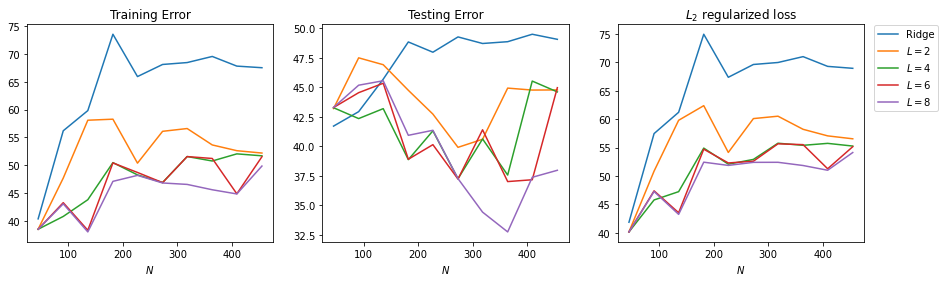

In [148]:

plot_MSE_new(loss_list_Boston_sigm_Norm,train_list_Boston_sigm_Norm,test_list_Boston_sigm_Norm)

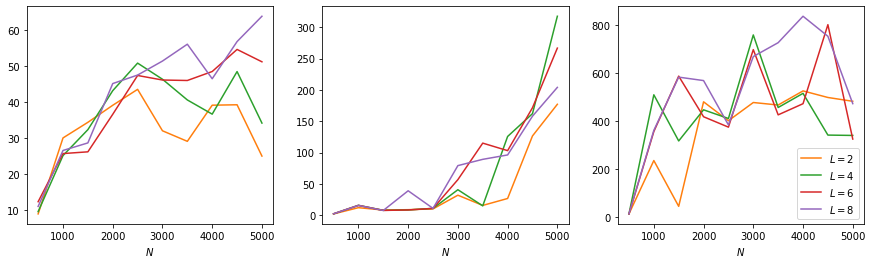

In [42]:
#alpha1min_list_synt_relu = list([alpha1min2L_synt_relu,alpha1min4L_synt_relu,alpha1min6L_synt_relu,
#                                 alpha1min8L_synt_relu])

#alpha1min_list_synt_tanh = list([alpha1min2L_synt_tanh,alpha1min4L_synt_tanh,alpha1min6L_synt_tanh,
#                                 alpha1min8L_synt_tanh])

#alpha1min_list_synt_sigm = list([alpha1min2L_synt_sigm,alpha1min4L_synt_sigm,alpha1min6L_synt_sigm,
#                                 alpha1min8L_synt_sigm])

from cycler import cycler

def alpha(alpha_relu,alpha_tanh,alpha_sigm):#,alpha_sigm):
    Layers=[2,4,6,8]
    c=1
    fig = plt.figure(figsize=(15,4)) 
    Ntrain=5000
    N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
   # N_list = np.array([50,100,200,400,800,1600])
    
    #plt.title('ReLU')
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    
    plt.subplot(1, 3, c)
    
    for alpha1min, L in zip(alpha_relu,Layers):
        alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
        
        plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1
    
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    plt.subplot(1, 3, c)
    for alpha1min, L in zip(alpha_tanh,Layers):
        alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
        plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1
    
    plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
    plt.subplot(1, 3, c)
    for alpha1min, L in zip(alpha_sigm,Layers):
        alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
        plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    plt.xlabel(r'$N$')
    #plt.yscale('log')
    c+=1
    
    #plt.subplot(1, 3, c)
    #for alpha1min, L in zip(alpha_sigm,Layers):
    #    alpha1norm=np.mean(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
    #    plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
    #plt.xlabel(r'$N_{train}$')
    #c+=1
    
    plt.legend()

    #dataset="Boston"

    #plt.savefig(f'alpha1_NEW_{dataset}.pdf')
    #plt.show()

    #plt.tight_layout()

alpha(alpha1min_list_Boston_relu_Norm,alpha1min_list_Boston_tanh_Norm,
      alpha1min_list_Boston_sigm_Norm)#,alpha1min_list_synt_sigm)

In [40]:
%store -r alpha1min_list_Boston_relu_Norm

In [2622]:
%store alpha1min_list_Boston_relu2
%store train_list_Boston_relu2
%store test_list_Boston_relu2
#%store alpha1min_list_synt_tanh
#%store alpha1min_list_synt_sigm

Stored 'alpha1min_list_Boston_relu2' (list)
Stored 'train_list_Boston_relu2' (list)
Stored 'test_list_Boston_relu2' (list)


## 3) Logistic map $X_{k+1}=4X_k(1-X_k)$

In [18]:
def logistic(r, x):
    return r * x * (1 - x)

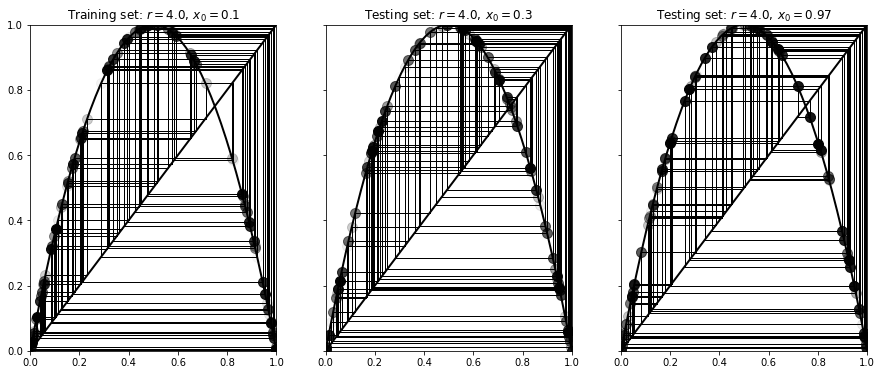

In [19]:
def plot_system(r, x0, n, ax=None,dataset="Training"):
    # Plot the function and the
    # y=x diagonal line.
    t = np.linspace(0, 1)
    ax.plot(t, logistic(r, t), 'k', lw=2)
    ax.plot([0, 1], [0, 1], 'k', lw=2)
    
    X_train=[]
    Y_train=[]
    
    # Recursively apply y=f(x) and plot two lines:
    # (x, x) -> (x, y)
    # (x, y) -> (y, y)
    
    x = x0
    for i in range(n):
        X_train.append(x)
        y = logistic(r, x)
        Y_train.append(y)
        # Plot the two lines.
        ax.plot([x, x], [x, y], 'k', lw=1)
        ax.plot([x, y], [y, y], 'k', lw=1)
        # Plot the positions with increasing
        # opacity.
        ax.plot([x], [y], 'ok', ms=10,
                alpha=(i + 1) / n)
        x = y
        
    X_train=np.array(X_train)[...,np.newaxis]
    Y_train=np.array(Y_train)[...,np.newaxis]    

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f"{dataset} set: $r={r:.1f}, \, x_0={x0}$")
    
    return (X_train, Y_train)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 6),
                               sharey=True)

x0_train=0.1
r_train=4

x0_test1=0.3
x0_test2=0.97
r_test=4



(X_train, Y_train) = plot_system(r_train, x0_train, 100, ax=ax1,dataset="Training")
(X_test1, Y_test1) = plot_system(r_test, x0_test1, 100, ax=ax2,dataset="Testing")
(X_test2, Y_test2) = plot_system(r_test, x0_test2, 100, ax=ax3,dataset="Testing")

In [20]:
## convert the data to torch tensor

vx_train=torch.tensor(X_train.astype('float64'))
vx_test1=torch.tensor(X_test1.astype('float64'))
vx_test2=torch.tensor(X_test2.astype('float64'))


y_train=torch.tensor(Y_train.astype('float64'))
y_test1=torch.tensor(Y_test1.astype('float64'))
y_test2=torch.tensor(Y_test2.astype('float64'))




In [21]:
def geterror_new(pred,y):
    z=y.numpy()
    return np.sqrt(np.sum((z-pred)**2)/len(y))

In [30]:
Ntest=200
_,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
_,alpha2_init=getalpha2_torch(vx_train,y_train)

def logistic_train(x0_test,N):
    pred_test=np.zeros((N,1))
    pred_test[0,:]=x0_test
    x=torch.tensor(np.array(x0_test).reshape(1,1))
    for i in range(N-1):
        pred=getYpred(phi_torch(x,alpha1min),alpha2min)
        pred_test[i+1,:]=pred.detach().numpy() 
        x=pred
        
    return pred_test

def logistic_notrain(x0_test,N):
    pred_test=np.zeros((N,1))
    pred_test[0,:]=x0_test
    x=torch.tensor(np.array(x0_test).reshape(1,1))
    for i in range(N-1):
        pred=getYpred(x,alpha2_init)
        pred_test[i+1,:]=pred.detach().numpy() 
        x=pred
        
    return pred_test
        

pred_train=logistic_notrain(x0_train,N=100)
pred_test1=logistic_notrain(x0_test1,N=100)
pred_test2=logistic_train(x0_test2,N=100)

        

    

In [ ]:
alpha1min_list_logistic_tanh = []
loss_list_logistic_tanh = []
test1_list_logistic_tanh = []
test2_list_logistic_tanh = []


N_list =  [50,100,200,400,800,1600]
Layers =  [2,4,6,8]
#for n in N_list:
#for rate in np.arange(0.1,1.1,0.1):

#Ntrain=n
#vx_train, y_train = getdata_train(Ntrain)
        
#def simulations():

activ="sigmoid"

for l in Layers:
    L=l
    
    alpha1min_list = []
    loss_list = []
    test1_list = []
    test2_list = []

    for N in N_list: 
        
        Ntrain=N
        (X_train, Y_train) = plot_system(r_train, x0_train, Ntrain, ax=ax1,dataset="Training")
        
        vx_train=torch.tensor(X_train.astype('float64'))
        y_train=torch.tensor(Y_train.astype('float64'))


        p = vx_train.shape[1]
        D1 = p+1
        D2 = 10*p

        random1="false"
        random2="true"
       
        
        gamma2=0.01
        nu=0.01
        lr=0.01

        alpha1min = optimize_alpha1(torch.zeros((D1,p,L),dtype=torch.float64),nsteps=1000,lr=lr)
        lmin = loss_torch(alpha1min)

        loss_list.append([lmin.detach().numpy(),loss_torch(torch.zeros((D1,p,L),dtype=torch.float64)).numpy()])
        alpha1min_list.append(alpha1min.detach().numpy())

        _,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
        _,alpha2_init=getalpha2_torch(vx_train,y_train)
        
        Ntest=100
        
        pred1_notrain=logistic_notrain(x0_test1,Ntest)
        pred1_train=logistic_train(x0_test1,Ntest)
        
        pred2_notrain=logistic_notrain(x0_test2,Ntest)
        pred2_train=logistic_train(x0_test2,Ntest)
        

        inierror_test1=geterror_new(pred1_notrain,vx_test1)
        finerror_test1=geterror_new(pred1_train,vx_test1)
        
        inierror_test2=geterror_new(pred2_notrain,vx_test1)
        finerror_test2=geterror_new(pred2_train,vx_test1)


        print('initial {} error= {}'.format("test 1",np.round(inierror_test1,3))) 
        print('final {} error= {}'.format("test 1",np.round(finerror_test1,3)))

        print('initial {} error= {}'.format("test 2",np.round(inierror_test2,3)))
        print('final {} error= {}'.format("test 2",np.round(finerror_test2,3)))

        test1_list.append(np.array([inierror_test1,finerror_test1]))
        test2_list.append((np.array([inierror_test2,finerror_test2])))
        

    alpha1min_list_logistic_tanh.append(alpha1min_list)
    loss_list_logistic_tanh.append(loss_list)
    test1_list_logistic_tanh.append(test1_list)
    test2_list_logistic_tanh.append(test2_list)




In [24]:
%store -r alpha1min_list_logistic_sigm
%store -r loss_list_logistic_sigm
%store -r test1_list_logistic_sigm
%store -r test2_list_logistic_sigm

<Figure size 1080x288 with 0 Axes>

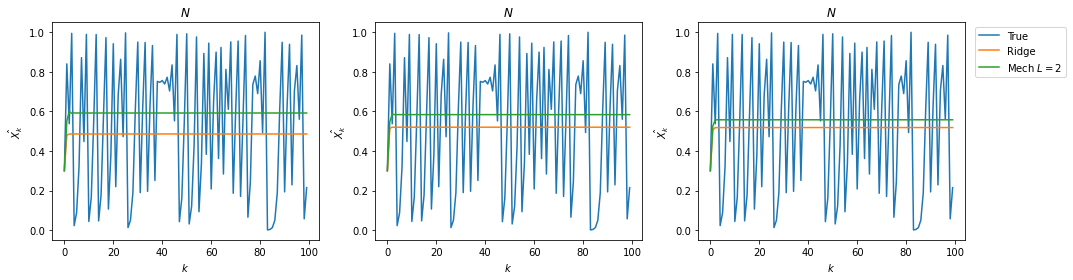

In [39]:
k_train=np.arange(0,100,1)
k_test=np.arange(0,100,1)

fig = plt.figure(figsize=(15,4)) 
    #Ntrain=5000
    #N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
  
    #perc_list=np.arange(10,110,10)


plt.rc('axes', prop_cycle=(cycler('color', ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))

alpha1min2L = alpha1min_list_logistic_sigm[0] # plot fit for 2 layers

fig = plt.figure(figsize=(15,4))
c=1
L=2

for i in range(1,6,2):
    
    
    Ntrain=N_list[i]
    (X_train, Y_train) = plot_system(r_train, x0_train, Ntrain, ax=ax1,dataset="Training")
        
    vx_train=torch.tensor(X_train.astype('float64'))
    y_train=torch.tensor(Y_train.astype('float64'))
    
    alpha1min=torch.tensor(alpha1min2L[i])
    _,alpha2min=getalpha2_torch(phi_torch(vx_train,alpha1min),y_train)
    _,alpha2_init=getalpha2_torch(vx_train,y_train)
    
    pred1_notrain=logistic_notrain(x0_test1,Ntest)
    pred1_train=logistic_train(x0_test1,Ntest)
    
    plt.subplot(1, 3, c)
    plt.title(f"$N$")
    plt.plot(k_test,vx_test1[:,0].detach().numpy(),label="True")
    plt.plot(k_test,pred1_notrain[:,0],label="Ridge")
    plt.plot(k_test,pred1_train[:,0],label=r"Mech $L=2$")
        #plt.legend(loc=(1.04,0.8))
    plt.ylabel(r"$\hat{X_k}$")
    plt.xlabel(r"$k$")
    c+=1
    
plt.legend(loc=(1.04,0.75))
    
    
    
plt.tight_layout()
dataset="logistic"
plt.savefig('fit2L_{}_{}_NORM.pdf'.format(dataset,activ))
    
    




        #c=1
    #plt.subplot(1, 2, c)
    #plt.title(f"Training set: $r={r_train:.1f}, \, x_0={x0_train}$")
    #plt.plot(k_train[1:],vx_train[1:,0],label="true")
    #plt.plot(k_train[1:],pred[:-1,0].detach().numpy(),label="predicted")
    #plt.legend()
    #plt.xlabel(r"$k$")





        #plt.subplot(1, 2, c)
        #plt.plot(k+1,pred_test[:,0].detach().numpy())
        #plt.xlabel(r"$k$")
        #plt.ylabel(r"$X(k)$")



        #plt.subplot(1, 2, c)
        #plt.scatter(vx_train[:,0],phi_torch(vx_train,alpha1min).detach().numpy()[:,0])
        #plt.xlabel(r"$X(k)$")
        #plt.ylabel(r"$\phi(X(k))$")





In [44]:
%store -r alpha1min_list_logistic_sigm

In [49]:
alpha1min=np.array(alpha1min_list_logistic_tanh[1])
np.sum(alpha1min**2,axis=(1)).shape

(6, 1, 4)

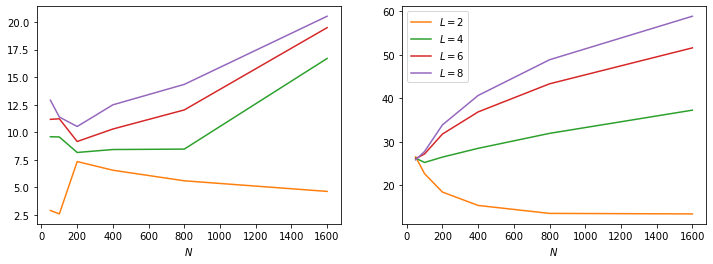

In [45]:
#N_list=[np.int(rate*Ntrain) for rate in np.arange(0.1,1.1,0.1)]
Layers=[2,4,6,8]
N_list=[50,100,200,400,800,1600]
plt.rc('axes', prop_cycle=(cycler('color', ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'])))
fig=plt.figure(figsize=(12,4)) 
c=1
plt.subplot(1,2,c)
for alpha1min, L in zip(alpha1min_list_logistic_tanh,Layers):
    alpha1norm=L*np.sum(np.sum(np.array(alpha1min)*np.array(alpha1min),axis=(1,2)),axis=1) # (10,) shape
    plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
plt.xlabel(r'$N$')
    #plt.yscale('log')
c+=1   
    
plt.subplot(1,2,c)
for alpha1min, L in zip(alpha1min_list_logistic_sigm,Layers):
    alpha1norm=L*np.sum(np.sum(np.array(alpha1min)**2,axis=(1,2)),axis=1) # (10,) shape
    plt.plot(N_list,alpha1norm,label=r'$L = {}$'.format(L))
plt.xlabel(r'$N$')
    #plt.yscale('log')
plt.legend()



dataset="logistic"
#plt.tight_layout()
#plt.savefig(f'alpha1_{dataset}.pdf')

